In [1]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pylab as pl
import matplotlib.pylab as plt
from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# FHV

In [2]:
fhv = pd.read_csv("output_fhv/fhv.csv")
nrow_fhv = fhv.shape[0]
print(fhv.shape)
fhv.head()

(12899039, 4)


,date,PUlocationID,DOlocationID,count
0,2015-01-01,0,0,10574
1,2015-01-03,0,0,13391
2,2015-01-04,0,0,13173
3,2015-01-13,0,0,21628
4,2015-01-15,0,0,24166


In [3]:
fhv.tail()

,date,PUlocationID,DOlocationID,count
12899034,2018-06-08,263,71,1
12899035,2018-06-06,174,14,1
12899036,2018-06-06,232,174,1
12899037,2018-06-29,20,25,1
12899038,2018-06-20,158,10,1


## outlier delete: done when cleaning with spark

def outlier_delete(x):
    if x in range(1,264):
        return x
    else:
        return 0

%%time
fhv['PUlocationID'] = fhv['PUlocationID'].apply(outlier_delete)
fhv['DOlocationID'] = fhv['DOlocationID'].apply(outlier_delete)

print("valid PUlocationID: ", len(fhv[fhv['PUlocationID']>=1])/nrow_fhv)
print("valid DOlocationID: ", len(fhv[fhv['DOlocationID']>=1])/nrow_fhv)

%%time
fhv.to_csv("output_fhv/fhv.csv")

sorted(fhv['PUlocationID'].unique())

sorted(fhv['DOlocationID'].unique())

## time series analysis

## time stamp conversion

In [4]:
fhv["date"] = pd.to_datetime(fhv["date"],format='%Y-%m-%d')
print(type(fhv["date"][0]))
fhv["date"][0]

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2015-01-01 00:00:00')

In [5]:
dates = fhv[['date']].drop_duplicates().sort_values(by='date').reset_index(drop=True)
print(dates.shape)
dates.head()

(1277, 1)


,date
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05


In [6]:
dates.tail()

,date
1272,2018-06-26
1273,2018-06-27
1274,2018-06-28
1275,2018-06-29
1276,2018-06-30


### daily overall activities

In [7]:
fhv_daily = fhv.groupby('date').sum()[['count']].sort_index()
fhv_daily.head()

,count
date,
2015-01-01,77789
2015-01-02,61832
2015-01-03,81955
2015-01-04,62691
2015-01-05,71063


In [8]:
fhv_daily.shape[0]

1277

Text(0.5, 1.0, 'time series for the number of daily fhv activities')

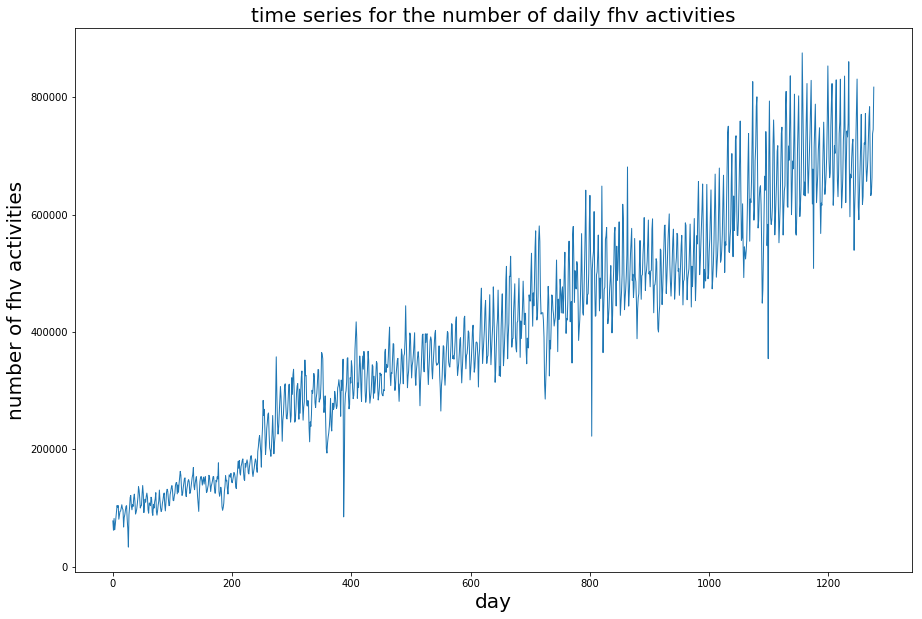

In [9]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(fhv_daily.shape[0]), fhv_daily['count'], '-', linewidth=1)
ax.set_ylabel('number of fhv activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for the number of daily fhv activities', fontsize=20)

### daily pickup activities

In [10]:
fhv_pickup = fhv.groupby(['date', 'PUlocationID']).sum()\
                .sort_index().reset_index()[['date', 'PUlocationID', 'count']]
print(fhv_pickup.shape)
fhv_pickup.head()

(329040, 3)


,date,PUlocationID,count
0,2015-01-01,0,13266
1,2015-01-01,1,1
2,2015-01-01,2,3
3,2015-01-01,3,29
4,2015-01-01,4,455


In [11]:
fhv_pickup_mean = fhv_pickup.groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
print(fhv_pickup_mean.shape)
fhv_pickup_mean.head()

(1277, 2)


,date,count
0,2015-01-01,308.686508
1,2015-01-02,253.409836
2,2015-01-03,323.932806
3,2015-01-04,255.881633
4,2015-01-05,290.053061


Wall time: 2.33 s


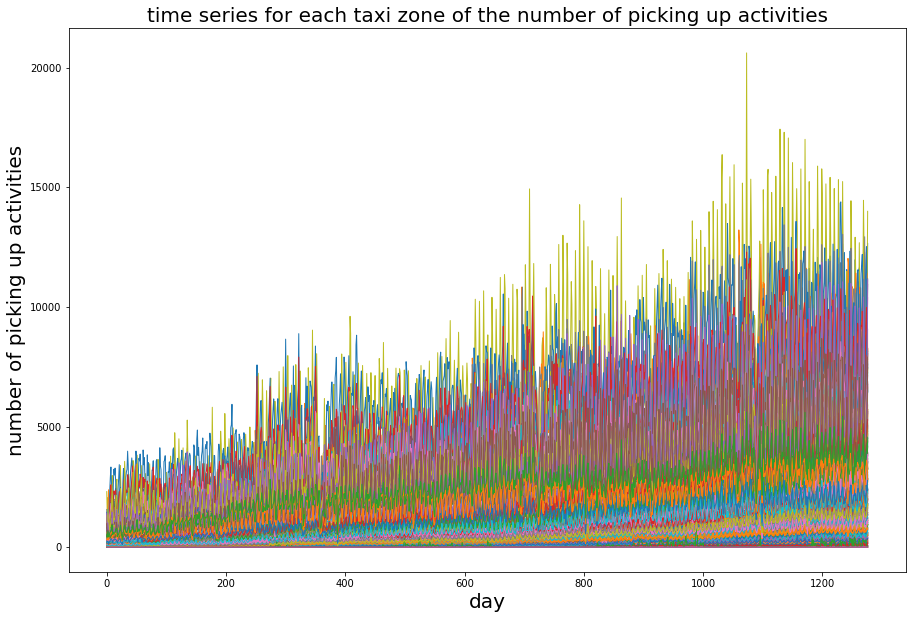

In [12]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(fhv_pickup['date'].unique())    
    count_deficient = fhv_pickup[fhv_pickup['PUlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1)
ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for each taxi zone of the number of picking up activities', fontsize=20)

Wall time: 2.11 s


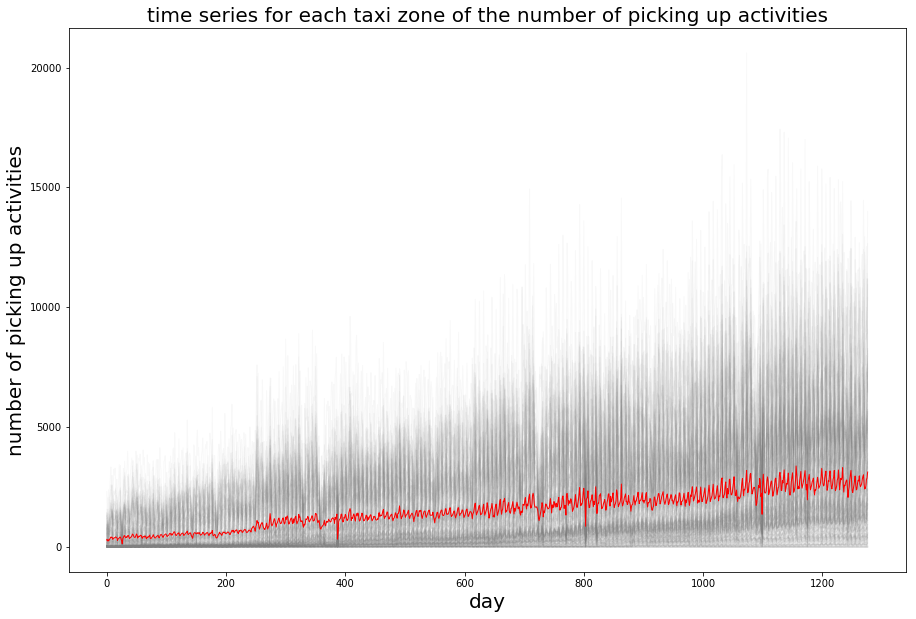

In [13]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(fhv_pickup['date'].unique())    
    count_deficient = fhv_pickup[fhv_pickup['PUlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1, alpha=0.05, color='grey')
ax.plot(range(num_days), fhv_pickup_mean['count'], '-', linewidth=1, alpha=1, color='r')
ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for each taxi zone of the number of picking up activities', fontsize=20)

### daily dropoff activities

In [14]:
fhv_dropoff = fhv.groupby(['date', 'DOlocationID']).sum()\
                .sort_index().reset_index()[['date', 'DOlocationID', 'count']]
print(fhv_dropoff.shape)
fhv_dropoff.head()

(107100, 3)


,date,DOlocationID,count
0,2015-01-01,0,77789
1,2015-01-02,0,61832
2,2015-01-03,0,81955
3,2015-01-04,0,62691
4,2015-01-05,0,71063


In [15]:
fhv_dropoff.tail()

,date,DOlocationID,count
107095,2018-06-30,259,1613
107096,2018-06-30,260,3276
107097,2018-06-30,261,2498
107098,2018-06-30,262,2439
107099,2018-06-30,263,4132


In [16]:
fhv_dropoff_mean = fhv_dropoff[fhv_dropoff['DOlocationID']!=0].groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
fhv_dropoff_mean = pd.merge(dates, fhv_dropoff_mean, on='date', how='left').fillna(0)
print(fhv_dropoff_mean.shape)
fhv_dropoff_mean.head()

(1277, 2)


,date,count
0,2015-01-01,0.0
1,2015-01-02,0.0
2,2015-01-03,0.0
3,2015-01-04,0.0
4,2015-01-05,0.0


fhv_dropoff_mean = fhv_dropoff.groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
fhv_dropoff_mean = pd.merge(dates, fhv_dropoff_mean, on='date', how='left').fillna(0)
print(fhv_dropoff_mean.shape)
fhv_dropoff_mean.head()

Wall time: 1.53 s


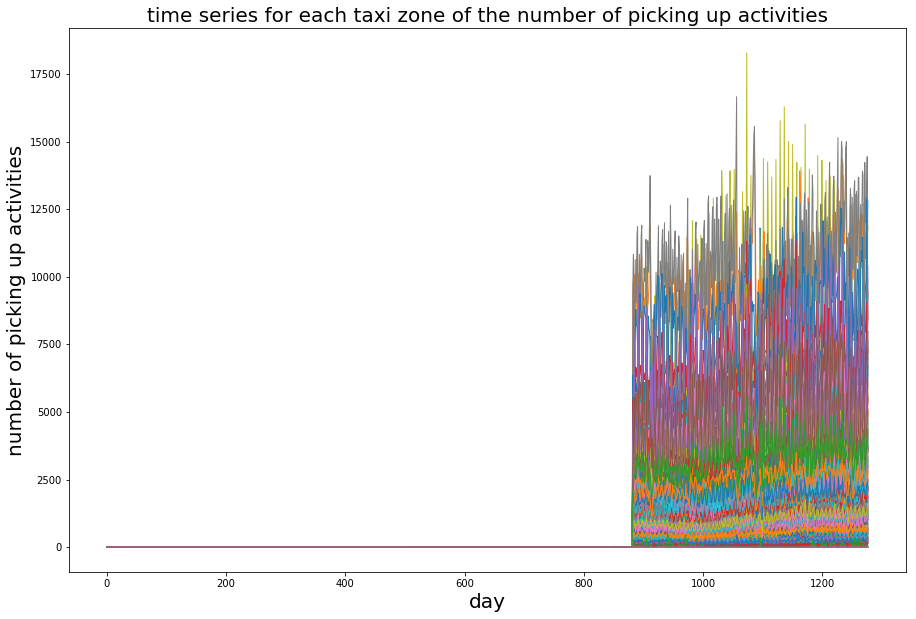

In [17]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(fhv_dropoff['date'].unique())    
    count_deficient = fhv_dropoff[fhv_dropoff['DOlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1)
ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for each taxi zone of the number of picking up activities', fontsize=20)


Wall time: 1.5 s


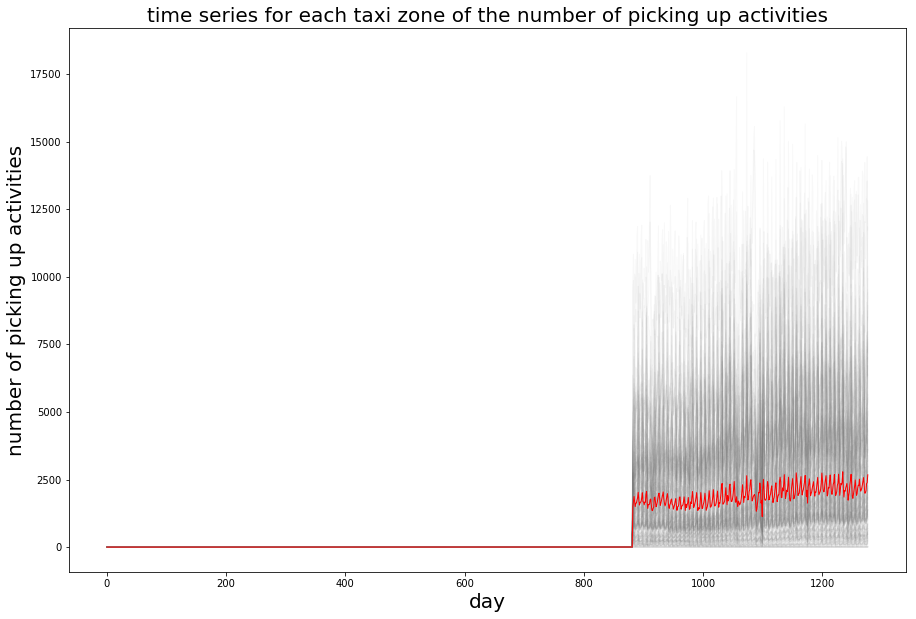

In [18]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(fhv_dropoff['date'].unique())    
    count_deficient = fhv_dropoff[fhv_dropoff['DOlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1, alpha=0.05, color='grey')

ax.plot(range(num_days), fhv_dropoff_mean['count'], '-', linewidth=1, alpha=1, color='r')

ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for each taxi zone of the number of picking up activities', fontsize=20)


## outlier detection

**The mean and stardand deviation of the time series can be used to set a 3-sigma threshold**  
**every value that is more then 3 sigmas away from the mean can be flagged as an event**

In [19]:
outlier = fhv_dropoff[fhv_dropoff['date']==fhv_dropoff['date'][len(fhv_dropoff)-1]]
outlier = outlier[outlier['count']== outlier['count'].max()]
DOlocationID_outlier = int(outlier['DOlocationID'])
print("The DOlocationID_outlier is:", DOlocationID_outlier)

The DOlocationID_outlier is: 0


## taxi zones geometry

In [20]:
if not os.path.isfile("taxi_zones/taxi_zones.shp"):    
    !curl https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip > taxi_zones.zip
    !mv taxi_zones.zip taxi_zones
    !unzip -o taxi_zones/taxi_zones.zip -d taxi_zones
else:
    print("file in place, you can continue")

file in place, you can continue


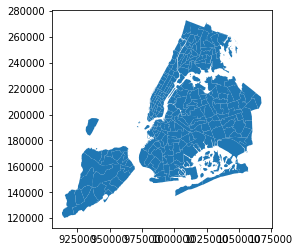

In [21]:
taxi_zones = gpd.read_file("taxi_zones/taxi_zones.shp")
taxi_zones.plot()

In [22]:
print(taxi_zones.shape)
taxi_zones.head()

(263, 7)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


http://geopandas.org/reference.html  
legend_kwds : dict (default None)  
Keyword arguments to pass to ax.legend()

### pick up

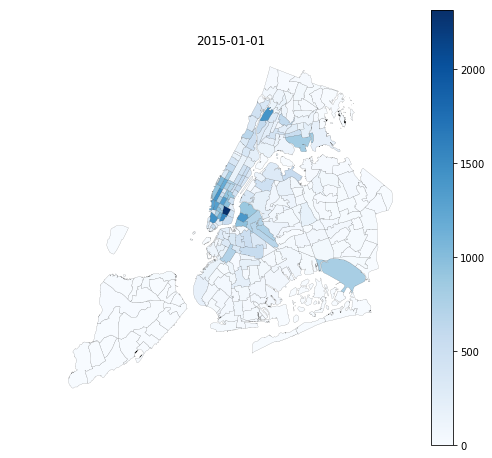

In [27]:
date = dates['date'][0]
fhv_pickup_plot = fhv_pickup[fhv_pickup['date']==date]
taxi_zones_plot = pd.merge(taxi_zones, fhv_pickup_plot, left_on = 'LocationID', right_on = 'PUlocationID', how='left')

fig, ax = plt.subplots(figsize=(8, 8))
taxi_zones_plot.fillna(0).plot(column = 'count', cmap='Blues', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
ax.set_axis_off()
plt.title(str(date)[:10])

fig.savefig('png_pickup/'+str(date)[:10])


%%time
for i in dates['date']:
    date = i
    fhv_pickup_plot = fhv_pickup[fhv_pickup['date']==date]
    taxi_zones_plot = pd.merge(taxi_zones, fhv_pickup_plot, left_on = 'LocationID', right_on = 'PUlocationID', how='left')

    fig, ax = plt.subplots(figsize=(8, 8))
    taxi_zones_plot.fillna(0).plot(column = 'count', cmap='Blues', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
    ax.set_axis_off()
    plt.title(str(date)[:10])

    fig.savefig('png_pickup/'+str(date)[:10])

# Tickets

## time stamp conversion

In [ ]:
tickets = pd.read_csv("output_tickets/tickets.csv")
tickets = tickets.groupby('date').sum().reset_index()
print(tickets.shape)
tickets.head()

In [ ]:
tickets["date"] = pd.to_datetime(tickets["date"],format='%m/%d/%Y')
tickets = tickets.sort_values(by = 'date')
tickets['year'] = tickets["date"].apply(lambda x: x.year)
tickets = tickets[(tickets['year'] > 2013) & (tickets['year'] < 2019)]
print(tickets.shape)
tickets.head()

In [ ]:
tickets.tail()

In [ ]:
len(tickets['date'].unique())

In [ ]:
len(tickets)

## time series analysis

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
num_days = len(tickets['date'].unique())
ax.plot(range(num_days), tickets['count'], '-', linewidth=1)
ax.set_ylabel('number of fhv activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for the number of daily parking tickets', fontsize=20)

## Integrated analysis

In [ ]:
integrated = pd.merge(dates, tickets, on = 'date', how='inner')
print(integrated.shape)
integrated.head()

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(fhv_daily.shape[0]), fhv_daily['count'], '-', linewidth=1, color='b')
ax.plot(range(fhv_daily.shape[0]), integrated['count'], '-', linewidth=1, color='r')

ax.set_ylabel('number of fhv activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for the number of daily fhv activities', fontsize=20)

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(fhv_daily.shape[0]), fhv_daily['count']/10, '-', linewidth=1, color='b')
ax.plot(range(fhv_daily.shape[0]), integrated['count'], '-', linewidth=1, color='r')

ax.set_ylabel('number of fhv activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for the number of daily fhv activities', fontsize=20)

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(fhv_daily.shape[0]), np.log(fhv_daily['count']), '-', linewidth=1, color='b')
ax.plot(range(fhv_daily.shape[0]), np.log(integrated['count']), '-', linewidth=1, color='r')

ax.set_ylabel('number of fhv activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for the number of daily fhv activities', fontsize=20)

# correlation analysis

In [ ]:
correlation = pd.merge(integrated, fhv_daily, on = 'date', how='inner')[['count_x', 'count_y']]
print(correlation.shape)
correlation.head()

In [ ]:
correlation.corr()